In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [2]:
batch_size = 512
epochs = 300
sample_size = 64 # fixed sample size
nz = 128 # latent vector size
k = 3 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.BatchNorm1d(784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(1024, 512)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(256, 1)),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [5]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Linear(in_features=1024, out_features=784, bias=True)
    (8): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): LeakyReLU(nega

In [6]:
# loss
criterion = nn.BCELoss() 

optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [7]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

def show_pics():
    fig = plt.figure()

    with torch.no_grad():
        test_z = create_noise(b_size, nz)
        generated = generator(test_z)

        pic = generated.view(generated.size(0), 1, 28, 28)

        for i in range(12):
            plt.subplot(3,4,i+1)
            plt.tight_layout()
            plt.imshow(transforms.ToPILImage()(pic[i]), cmap='gray', interpolation='none')
            plt.xticks([])
            plt.yticks([])
    return fig

In [8]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)

    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()

    optimizer.step()

    return loss_real + loss_fake

In [9]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    
    real_label = label_real(b_size)
    
    optimizer.zero_grad()
    
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    
    loss.backward()
    
    optimizer.step()

    pbar.update(pbar_update)

    return loss

  0%|          | 1.0084745762711846/300 [00:12<57:41, 11.58s/it]  

	Epoch 1 of 300	Generator loss: 3.69700384, Discriminator loss: 0.25392255


  1%|          | 2.0169491525423684/300 [00:24<53:56, 10.86s/it]

	Epoch 2 of 300	Generator loss: 5.20969009, Discriminator loss: 0.23404640


  1%|          | 3.0084745762711793/300 [00:35<51:46, 10.46s/it]

	Epoch 3 of 300	Generator loss: 6.68612051, Discriminator loss: 0.20934112


  1%|▏         | 4.008474576271177/300 [00:46<50:03, 10.15s/it]

	Epoch 4 of 300	Generator loss: 6.69337559, Discriminator loss: 0.12629870


  2%|▏         | 5.008474576271227/300 [00:58<56:04, 11.41s/it]  

	Epoch 5 of 300	Generator loss: 6.97823334, Discriminator loss: 0.10757042


  2%|▏         | 6.008474576271277/300 [01:10<56:30, 11.53s/it]  

	Epoch 6 of 300	Generator loss: 7.62486267, Discriminator loss: 0.05667680


  2%|▏         | 7.008474576271326/300 [01:22<50:29, 10.34s/it]

	Epoch 7 of 300	Generator loss: 8.25633526, Discriminator loss: 0.05946690


  3%|▎         | 8.008474576271375/300 [01:34<51:18, 10.54s/it]

	Epoch 8 of 300	Generator loss: 8.05594349, Discriminator loss: 0.06292757


  3%|▎         | 9.008474576271425/300 [01:45<49:30, 10.21s/it]

	Epoch 9 of 300	Generator loss: 8.07078457, Discriminator loss: 0.08418185


  3%|▎         | 10.008474576271475/300 [01:56<49:25, 10.23s/it]

	Epoch 10 of 300	Generator loss: 8.10761833, Discriminator loss: 0.08784474


  4%|▎         | 11.008474576271524/300 [02:08<53:41, 11.15s/it]

	Epoch 11 of 300	Generator loss: 8.24174309, Discriminator loss: 0.10082805


  4%|▍         | 12.008474576271574/300 [02:20<54:11, 11.29s/it]

	Epoch 12 of 300	Generator loss: 8.32586098, Discriminator loss: 0.09911974


  4%|▍         | 13.01694915254281/300 [02:32<51:17, 10.72s/it] 

	Epoch 13 of 300	Generator loss: 8.09944153, Discriminator loss: 0.08083331


  5%|▍         | 14.01694915254286/300 [02:43<50:47, 10.66s/it] 

	Epoch 14 of 300	Generator loss: 7.78756523, Discriminator loss: 0.10786045


  5%|▌         | 15.01694915254291/300 [02:54<49:48, 10.49s/it] 

	Epoch 15 of 300	Generator loss: 8.15877342, Discriminator loss: 0.12611850


  5%|▌         | 16.01694915254296/300 [03:05<48:40, 10.28s/it] 

	Epoch 16 of 300	Generator loss: 8.19401646, Discriminator loss: 0.11461868


  6%|▌         | 17.008474576271823/300 [03:17<51:29, 10.92s/it]

	Epoch 17 of 300	Generator loss: 8.01695442, Discriminator loss: 0.10192465


  6%|▌         | 18.008474576271873/300 [03:29<53:26, 11.37s/it]

	Epoch 18 of 300	Generator loss: 7.88753223, Discriminator loss: 0.11572049


  6%|▋         | 19.008474576271922/300 [03:41<52:57, 11.31s/it]

	Epoch 19 of 300	Generator loss: 7.89901352, Discriminator loss: 0.11417925


  7%|▋         | 20.008474576271972/300 [03:53<54:11, 11.61s/it]

	Epoch 20 of 300	Generator loss: 7.96273041, Discriminator loss: 0.10453734


  7%|▋         | 21.00847457627202/300 [04:06<54:16, 11.67s/it] 

	Epoch 21 of 300	Generator loss: 8.03032017, Discriminator loss: 0.12960990


  7%|▋         | 22.00847457627207/300 [04:18<47:45, 10.31s/it] 

	Epoch 22 of 300	Generator loss: 8.12269402, Discriminator loss: 0.11799037


  8%|▊         | 23.00847457627212/300 [04:29<48:57, 10.60s/it] 

	Epoch 23 of 300	Generator loss: 8.06495571, Discriminator loss: 0.11522533


  8%|▊         | 24.00847457627217/300 [04:41<47:27, 10.32s/it] 

	Epoch 24 of 300	Generator loss: 7.88687420, Discriminator loss: 0.12468585


  8%|▊         | 25.00847457627222/300 [04:53<52:31, 11.46s/it] 

	Epoch 25 of 300	Generator loss: 7.77897453, Discriminator loss: 0.12169708


  9%|▊         | 26.00847457627227/300 [05:05<52:06, 11.41s/it] 

	Epoch 26 of 300	Generator loss: 7.86769915, Discriminator loss: 0.12986881


  9%|▉         | 27.00847457627232/300 [05:17<47:19, 10.40s/it] 

	Epoch 27 of 300	Generator loss: 7.63958120, Discriminator loss: 0.12407836


  9%|▉         | 28.00847457627237/300 [05:28<47:01, 10.37s/it] 

	Epoch 28 of 300	Generator loss: 7.77021313, Discriminator loss: 0.12548080


 10%|▉         | 29.00847457627242/300 [05:40<47:48, 10.58s/it] 

	Epoch 29 of 300	Generator loss: 7.75669479, Discriminator loss: 0.11347811


 10%|█         | 30.00847457627247/300 [05:51<47:27, 10.55s/it] 

	Epoch 30 of 300	Generator loss: 7.70114231, Discriminator loss: 0.15497336


 10%|█         | 31.00847457627252/300 [06:03<51:32, 11.50s/it] 

	Epoch 31 of 300	Generator loss: 7.44835472, Discriminator loss: 0.14155728


 11%|█         | 32.00847457627256/300 [06:16<52:13, 11.69s/it] 

	Epoch 32 of 300	Generator loss: 7.40594292, Discriminator loss: 0.13497844


 11%|█         | 33.016949152543376/300 [06:28<48:04, 10.80s/it]

	Epoch 33 of 300	Generator loss: 7.45279312, Discriminator loss: 0.13300091


 11%|█▏        | 34.016949152543006/300 [06:39<47:23, 10.69s/it]

	Epoch 34 of 300	Generator loss: 7.22904062, Discriminator loss: 0.14483012


 12%|█▏        | 35.00847457627145/300 [06:50<50:11, 11.36s/it]

	Epoch 35 of 300	Generator loss: 7.16638327, Discriminator loss: 0.13464266


 12%|█▏        | 36.008474576271084/300 [07:02<50:15, 11.42s/it]

	Epoch 36 of 300	Generator loss: 7.19745255, Discriminator loss: 0.13778257


 12%|█▏        | 37.008474576270714/300 [07:15<50:26, 11.51s/it]

	Epoch 37 of 300	Generator loss: 7.13952971, Discriminator loss: 0.14772031


 13%|█▎        | 38.01694915254153/300 [07:27<46:38, 10.68s/it]

	Epoch 38 of 300	Generator loss: 7.07749414, Discriminator loss: 0.15027525


 13%|█▎        | 39.008474576269975/300 [07:38<46:43, 10.74s/it]

	Epoch 39 of 300	Generator loss: 7.17378998, Discriminator loss: 0.13387163


 13%|█▎        | 40.008474576269606/300 [07:50<45:07, 10.41s/it]

	Epoch 40 of 300	Generator loss: 7.10831499, Discriminator loss: 0.14120008


 14%|█▎        | 41.008474576269236/300 [08:01<44:17, 10.26s/it]

	Epoch 41 of 300	Generator loss: 7.00031471, Discriminator loss: 0.14725457


 14%|█▍        | 42.00847457626887/300 [08:13<48:27, 11.27s/it]

	Epoch 42 of 300	Generator loss: 6.82600498, Discriminator loss: 0.14952931


 14%|█▍        | 43.0084745762685/300 [08:25<48:19, 11.28s/it] 

	Epoch 43 of 300	Generator loss: 6.70836878, Discriminator loss: 0.15443695


 15%|█▍        | 44.00847457626813/300 [08:37<46:07, 10.81s/it]

	Epoch 44 of 300	Generator loss: 6.92556810, Discriminator loss: 0.15807070


 15%|█▌        | 45.00847457626776/300 [08:49<44:05, 10.38s/it]

	Epoch 45 of 300	Generator loss: 6.62024021, Discriminator loss: 0.17851390


 15%|█▌        | 46.00847457626739/300 [09:00<44:22, 10.48s/it]

	Epoch 46 of 300	Generator loss: 6.73965836, Discriminator loss: 0.16231306


 16%|█▌        | 47.00847457626702/300 [09:12<49:03, 11.64s/it]

	Epoch 47 of 300	Generator loss: 6.45747614, Discriminator loss: 0.17927535


 16%|█▌        | 48.00847457626665/300 [09:24<53:34, 12.76s/it]  

	Epoch 48 of 300	Generator loss: 6.41254520, Discriminator loss: 0.18058144


 16%|█▋        | 49.00847457626628/300 [09:37<44:30, 10.64s/it] 

	Epoch 49 of 300	Generator loss: 6.26284552, Discriminator loss: 0.18793795


 17%|█▋        | 49.991525423723544/300 [09:48<54:27, 13.07s/it]

	Epoch 50 of 300	Generator loss: 6.19406748, Discriminator loss: 0.17902967


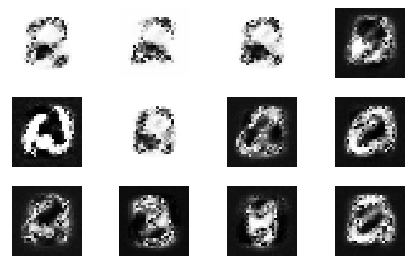

 17%|█▋        | 51.00847457626554/300 [10:02<47:38, 11.48s/it] 

	Epoch 51 of 300	Generator loss: 6.19570732, Discriminator loss: 0.19221598


 17%|█▋        | 52.00847457626517/300 [10:14<44:09, 10.68s/it] 

	Epoch 52 of 300	Generator loss: 5.98417282, Discriminator loss: 0.20851000


 18%|█▊        | 53.0084745762648/300 [10:26<43:11, 10.49s/it]  

	Epoch 53 of 300	Generator loss: 5.90815210, Discriminator loss: 0.19871962


 18%|█▊        | 54.00847457626443/300 [10:37<43:13, 10.54s/it]

	Epoch 54 of 300	Generator loss: 5.84777641, Discriminator loss: 0.24463294


 18%|█▊        | 55.008474576264064/300 [10:49<44:03, 10.79s/it]

	Epoch 55 of 300	Generator loss: 5.80105495, Discriminator loss: 0.23438546


 19%|█▊        | 56.008474576263694/300 [11:01<46:32, 11.44s/it]

	Epoch 56 of 300	Generator loss: 5.72344017, Discriminator loss: 0.24485284


 19%|█▉        | 57.008474576263325/300 [11:14<45:09, 11.15s/it]

	Epoch 57 of 300	Generator loss: 5.54660225, Discriminator loss: 0.27315432


 19%|█▉        | 58.008474576262955/300 [11:27<44:19, 10.99s/it]

	Epoch 58 of 300	Generator loss: 5.51988363, Discriminator loss: 0.28625721


 20%|█▉        | 59.008474576262586/300 [11:39<44:39, 11.12s/it]

	Epoch 59 of 300	Generator loss: 5.23883486, Discriminator loss: 0.31540394


 20%|██        | 60.008474576262216/300 [11:51<44:45, 11.19s/it]

	Epoch 60 of 300	Generator loss: 5.28936338, Discriminator loss: 0.30616787


 20%|██        | 61.00847457626185/300 [12:04<46:16, 11.62s/it]

	Epoch 61 of 300	Generator loss: 5.27557039, Discriminator loss: 0.28879091


 21%|██        | 62.00847457626148/300 [12:16<44:54, 11.32s/it]

	Epoch 62 of 300	Generator loss: 5.10670280, Discriminator loss: 0.30997735


 21%|██        | 63.01694915253229/300 [12:28<43:28, 11.01s/it] 

	Epoch 63 of 300	Generator loss: 5.09757137, Discriminator loss: 0.30361623


 21%|██▏       | 64.01694915253192/300 [12:40<42:24, 10.78s/it] 

	Epoch 64 of 300	Generator loss: 5.03609610, Discriminator loss: 0.31405967


 22%|██▏       | 65.01694915253155/300 [12:51<42:17, 10.80s/it]

	Epoch 65 of 300	Generator loss: 4.95827579, Discriminator loss: 0.34329617


 22%|██▏       | 66.00847457626/300 [13:03<46:18, 11.87s/it]   

	Epoch 66 of 300	Generator loss: 4.95888805, Discriminator loss: 0.33326843


 22%|██▏       | 67.00847457625963/300 [13:15<44:22, 11.43s/it]

	Epoch 67 of 300	Generator loss: 4.71836901, Discriminator loss: 0.37361950


 23%|██▎       | 68.00847457625926/300 [13:28<40:28, 10.47s/it]

	Epoch 68 of 300	Generator loss: 4.71471024, Discriminator loss: 0.36115548


 23%|██▎       | 69.01694915253007/300 [13:39<41:38, 10.82s/it]

	Epoch 69 of 300	Generator loss: 4.62048292, Discriminator loss: 0.40250435


 23%|██▎       | 70.0169491525297/300 [13:51<42:26, 11.07s/it] 

	Epoch 70 of 300	Generator loss: 4.57274723, Discriminator loss: 0.39605343


 24%|██▎       | 71.01694915252934/300 [14:03<41:25, 10.85s/it]

	Epoch 71 of 300	Generator loss: 4.34128618, Discriminator loss: 0.49856865


 24%|██▍       | 72.00847457625778/300 [14:15<46:12, 12.16s/it]

	Epoch 72 of 300	Generator loss: 4.26161528, Discriminator loss: 0.51416618


 24%|██▍       | 73.00847457625741/300 [14:28<44:38, 11.80s/it]

	Epoch 73 of 300	Generator loss: 4.14596653, Discriminator loss: 0.49828649


 25%|██▍       | 74.00847457625704/300 [14:41<45:10, 11.99s/it]

	Epoch 74 of 300	Generator loss: 4.16951656, Discriminator loss: 0.52458048


 25%|██▌       | 75.00847457625667/300 [14:54<44:51, 11.96s/it]

	Epoch 75 of 300	Generator loss: 3.95393515, Discriminator loss: 0.56311309


 25%|██▌       | 76.01694915252749/300 [15:07<42:10, 11.30s/it]

	Epoch 76 of 300	Generator loss: 3.94836569, Discriminator loss: 0.54162526


 26%|██▌       | 77.01694915252712/300 [15:19<41:16, 11.11s/it]

	Epoch 77 of 300	Generator loss: 3.85420084, Discriminator loss: 0.56714720


 26%|██▌       | 77.99999999998438/300 [15:31<38:22, 10.37s/it]

	Epoch 78 of 300	Generator loss: 3.79313993, Discriminator loss: 0.63937068


 26%|██▋       | 79.0084745762552/300 [15:42<40:48, 11.08s/it] 

	Epoch 79 of 300	Generator loss: 3.78686237, Discriminator loss: 0.60785383


 27%|██▋       | 80.00847457625483/300 [15:55<43:09, 11.77s/it]

	Epoch 80 of 300	Generator loss: 3.73870254, Discriminator loss: 0.61737418


 27%|██▋       | 81.00847457625446/300 [16:08<43:31, 11.93s/it]

	Epoch 81 of 300	Generator loss: 3.60429311, Discriminator loss: 0.66664922


 27%|██▋       | 82.00847457625409/300 [16:20<39:55, 10.99s/it]

	Epoch 82 of 300	Generator loss: 3.58997583, Discriminator loss: 0.69370919


 28%|██▊       | 83.0169491525249/300 [16:32<41:04, 11.36s/it] 

	Epoch 83 of 300	Generator loss: 3.56952214, Discriminator loss: 0.72092855


 28%|██▊       | 84.00847457625335/300 [16:43<38:58, 10.83s/it]

	Epoch 84 of 300	Generator loss: 3.47868323, Discriminator loss: 0.75174886


 28%|██▊       | 85.00847457625298/300 [16:55<41:19, 11.53s/it]

	Epoch 85 of 300	Generator loss: 3.43252349, Discriminator loss: 0.76420480


 29%|██▊       | 86.00847457625261/300 [17:07<41:03, 11.51s/it]

	Epoch 86 of 300	Generator loss: 3.32707453, Discriminator loss: 0.79071653


 29%|██▉       | 87.01694915252342/300 [17:20<37:36, 10.60s/it]

	Epoch 87 of 300	Generator loss: 3.29998064, Discriminator loss: 0.82906270


 29%|██▉       | 88.01694915252305/300 [17:31<37:48, 10.70s/it]

	Epoch 88 of 300	Generator loss: 3.18141270, Discriminator loss: 0.85088837


 30%|██▉       | 89.01694915252268/300 [17:43<38:16, 10.88s/it]

	Epoch 89 of 300	Generator loss: 3.13753295, Discriminator loss: 0.88966900


 30%|███       | 90.00847457625113/300 [17:54<36:54, 10.54s/it]

	Epoch 90 of 300	Generator loss: 3.03469157, Discriminator loss: 0.84165692


 30%|███       | 91.00847457625076/300 [18:07<39:55, 11.46s/it]

	Epoch 91 of 300	Generator loss: 3.00950694, Discriminator loss: 0.89214802


 31%|███       | 92.00847457625039/300 [18:19<40:25, 11.66s/it]

	Epoch 92 of 300	Generator loss: 2.98252892, Discriminator loss: 0.93017304


 31%|███       | 93.0169491525212/300 [18:31<38:30, 11.16s/it] 

	Epoch 93 of 300	Generator loss: 2.92323184, Discriminator loss: 0.94111121


 31%|███▏      | 94.00847457624965/300 [18:43<38:34, 11.23s/it]

	Epoch 94 of 300	Generator loss: 2.87114310, Discriminator loss: 0.99621212


 32%|███▏      | 95.01694915252047/300 [18:56<38:15, 11.20s/it]

	Epoch 95 of 300	Generator loss: 2.80930090, Discriminator loss: 1.05273902


 32%|███▏      | 96.00847457624891/300 [19:08<40:54, 12.03s/it]

	Epoch 96 of 300	Generator loss: 2.75922060, Discriminator loss: 1.07349384


 32%|███▏      | 97.00847457624855/300 [19:21<40:39, 12.02s/it]

	Epoch 97 of 300	Generator loss: 2.72508240, Discriminator loss: 1.13530862


 33%|███▎      | 98.01694915251936/300 [19:34<36:42, 10.91s/it]

	Epoch 98 of 300	Generator loss: 2.64332533, Discriminator loss: 1.16810644


 33%|███▎      | 99.0084745762478/300 [19:45<35:31, 10.60s/it] 

	Epoch 99 of 300	Generator loss: 2.56389785, Discriminator loss: 1.20197809


 33%|███▎      | 99.99999999997625/300 [19:57<35:20, 10.60s/it]

	Epoch 100 of 300	Generator loss: 2.58784199, Discriminator loss: 1.23641503


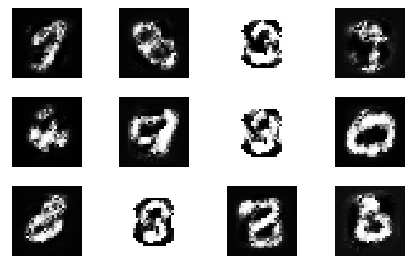

 34%|███▎      | 101.00847457624707/300 [20:09<35:45, 10.78s/it]

	Epoch 101 of 300	Generator loss: 2.49506974, Discriminator loss: 1.22652280


 34%|███▍      | 102.0084745762467/300 [20:22<37:51, 11.47s/it] 

	Epoch 102 of 300	Generator loss: 2.54044819, Discriminator loss: 1.30873239


 34%|███▍      | 103.00847457624633/300 [20:34<37:36, 11.45s/it]

	Epoch 103 of 300	Generator loss: 2.52053428, Discriminator loss: 1.32714880


 35%|███▍      | 104.00847457624596/300 [20:46<37:56, 11.62s/it]

	Epoch 104 of 300	Generator loss: 2.38409257, Discriminator loss: 1.34357274


 35%|███▌      | 105.00847457624559/300 [20:59<37:35, 11.57s/it]

	Epoch 105 of 300	Generator loss: 2.31555009, Discriminator loss: 1.40692055


 35%|███▌      | 106.00847457624522/300 [21:11<35:19, 10.92s/it]

	Epoch 106 of 300	Generator loss: 2.29446006, Discriminator loss: 1.47124386


 36%|███▌      | 107.00847457624485/300 [21:22<34:49, 10.83s/it]

	Epoch 107 of 300	Generator loss: 2.23747182, Discriminator loss: 1.44184995


 36%|███▌      | 108.00847457624448/300 [21:34<33:15, 10.39s/it]

	Epoch 108 of 300	Generator loss: 2.22636104, Discriminator loss: 1.49751222


 36%|███▋      | 109.0169491525153/300 [21:45<34:48, 10.93s/it] 

	Epoch 109 of 300	Generator loss: 2.21554184, Discriminator loss: 1.52991426


 37%|███▋      | 110.00847457624374/300 [21:58<36:43, 11.60s/it]

	Epoch 110 of 300	Generator loss: 2.11736917, Discriminator loss: 1.59564781


 37%|███▋      | 111.00847457624337/300 [22:10<37:15, 11.83s/it]

	Epoch 111 of 300	Generator loss: 2.14314175, Discriminator loss: 1.68019724


 37%|███▋      | 111.99999999997182/300 [22:22<32:31, 10.38s/it]

	Epoch 112 of 300	Generator loss: 2.18391538, Discriminator loss: 1.69015813


 38%|███▊      | 113.00847457624263/300 [22:34<32:43, 10.50s/it]

	Epoch 113 of 300	Generator loss: 2.45245194, Discriminator loss: 1.47637200


 38%|███▊      | 114.00847457624226/300 [22:45<32:13, 10.39s/it]

	Epoch 114 of 300	Generator loss: 2.34782696, Discriminator loss: 1.58830547


 38%|███▊      | 115.0084745762419/300 [22:57<35:17, 11.45s/it] 

	Epoch 115 of 300	Generator loss: 2.30004168, Discriminator loss: 1.66223073


 39%|███▊      | 116.00847457624153/300 [23:09<35:30, 11.58s/it]

	Epoch 116 of 300	Generator loss: 2.30561566, Discriminator loss: 1.71937382


 39%|███▉      | 117.00847457624116/300 [23:22<34:32, 11.33s/it]

	Epoch 117 of 300	Generator loss: 2.35547113, Discriminator loss: 1.71626496


 39%|███▉      | 118.00847457624079/300 [23:33<31:52, 10.51s/it]

	Epoch 118 of 300	Generator loss: 2.25654221, Discriminator loss: 1.70666373


 40%|███▉      | 119.00847457624042/300 [23:45<34:07, 11.32s/it]

	Epoch 119 of 300	Generator loss: 2.19313860, Discriminator loss: 1.74687231


 40%|████      | 120.01694915251123/300 [23:57<32:16, 10.76s/it]

	Epoch 120 of 300	Generator loss: 2.27419972, Discriminator loss: 1.78697574


 40%|████      | 121.00847457623968/300 [24:10<34:25, 11.54s/it]

	Epoch 121 of 300	Generator loss: 2.15682364, Discriminator loss: 1.84368706


 41%|████      | 122.00847457623931/300 [24:22<34:09, 11.52s/it]

	Epoch 122 of 300	Generator loss: 2.11772537, Discriminator loss: 1.85526836


 41%|████      | 123.00847457623894/300 [24:34<31:23, 10.64s/it]

	Epoch 123 of 300	Generator loss: 2.11345744, Discriminator loss: 1.86417210


 41%|████▏     | 124.00847457623857/300 [24:45<30:10, 10.29s/it]

	Epoch 124 of 300	Generator loss: 2.10476637, Discriminator loss: 1.93797719


 42%|████▏     | 125.0084745762382/300 [24:56<29:58, 10.28s/it] 

	Epoch 125 of 300	Generator loss: 2.23332024, Discriminator loss: 1.94863403


 42%|████▏     | 126.00847457623783/300 [25:08<30:06, 10.38s/it]

	Epoch 126 of 300	Generator loss: 2.18873978, Discriminator loss: 1.95768321


 42%|████▏     | 127.00847457623746/300 [25:20<32:40, 11.33s/it]

	Epoch 127 of 300	Generator loss: 2.18682456, Discriminator loss: 1.96967399


 43%|████▎     | 128.0169491525083/300 [25:32<31:43, 11.07s/it] 

	Epoch 128 of 300	Generator loss: 2.16088843, Discriminator loss: 2.00560665


 43%|████▎     | 129.0084745762384/300 [25:43<31:36, 11.09s/it]

	Epoch 129 of 300	Generator loss: 2.12906218, Discriminator loss: 2.05654502


 43%|████▎     | 130.0084745762397/300 [25:56<31:35, 11.15s/it]

	Epoch 130 of 300	Generator loss: 2.22364998, Discriminator loss: 1.96682262


 44%|████▎     | 131.0169491525122/300 [26:08<29:17, 10.40s/it] 

	Epoch 131 of 300	Generator loss: 2.15817666, Discriminator loss: 2.02733707


 44%|████▍     | 132.01694915251352/300 [26:19<29:55, 10.69s/it]

	Epoch 132 of 300	Generator loss: 2.06526780, Discriminator loss: 2.09453106


 44%|████▍     | 133.01694915251483/300 [26:30<29:00, 10.42s/it]

	Epoch 133 of 300	Generator loss: 2.09399462, Discriminator loss: 2.11375213


 45%|████▍     | 134.01694915251613/300 [26:41<28:46, 10.40s/it]

	Epoch 134 of 300	Generator loss: 2.26323414, Discriminator loss: 2.06186867


 45%|████▌     | 135.00847457624624/300 [26:53<31:08, 11.33s/it]

	Epoch 135 of 300	Generator loss: 2.14795804, Discriminator loss: 2.15783453


 45%|████▌     | 136.00847457624755/300 [27:05<30:20, 11.10s/it]

	Epoch 136 of 300	Generator loss: 1.99818933, Discriminator loss: 2.14589643


 46%|████▌     | 137.00847457624886/300 [27:17<27:41, 10.19s/it]

	Epoch 137 of 300	Generator loss: 2.01708031, Discriminator loss: 2.18545485


 46%|████▌     | 138.00847457625017/300 [27:28<27:19, 10.12s/it]

	Epoch 138 of 300	Generator loss: 2.06634140, Discriminator loss: 2.15334654


 46%|████▋     | 139.00847457625147/300 [27:39<27:04, 10.09s/it]

	Epoch 139 of 300	Generator loss: 2.06205487, Discriminator loss: 2.22485113


 47%|████▋     | 140.00847457625278/300 [27:50<27:18, 10.24s/it]

	Epoch 140 of 300	Generator loss: 1.99504876, Discriminator loss: 2.26117086


 47%|████▋     | 141.0084745762541/300 [28:02<29:53, 11.28s/it]

	Epoch 141 of 300	Generator loss: 2.06069541, Discriminator loss: 2.24216056


 47%|████▋     | 141.9999999999842/300 [28:14<28:53, 10.97s/it]

	Epoch 142 of 300	Generator loss: 2.12183404, Discriminator loss: 2.25379848


 48%|████▊     | 143.0169491525279/300 [28:26<26:45, 10.23s/it]

	Epoch 143 of 300	Generator loss: 2.12599134, Discriminator loss: 2.26866651


 48%|████▊     | 144.0169491525292/300 [28:36<26:57, 10.37s/it]

	Epoch 144 of 300	Generator loss: 1.93219745, Discriminator loss: 2.31389213


 48%|████▊     | 145.01694915253051/300 [28:47<26:18, 10.19s/it]

	Epoch 145 of 300	Generator loss: 2.00820947, Discriminator loss: 2.32876897


 49%|████▊     | 146.01694915253182/300 [28:58<26:17, 10.25s/it]

	Epoch 146 of 300	Generator loss: 2.01165414, Discriminator loss: 2.31984210


 49%|████▉     | 147.00847457626193/300 [29:10<27:54, 10.95s/it]

	Epoch 147 of 300	Generator loss: 2.06312847, Discriminator loss: 2.31786537


 49%|████▉     | 148.00847457626324/300 [29:22<27:40, 10.93s/it]

	Epoch 148 of 300	Generator loss: 1.95785189, Discriminator loss: 2.38334107


 50%|████▉     | 149.00847457626455/300 [29:33<24:33,  9.76s/it]

	Epoch 149 of 300	Generator loss: 1.86282980, Discriminator loss: 2.43863106


 50%|████▉     | 149.99152542372346/300 [29:44<27:31, 11.01s/it]

	Epoch 150 of 300	Generator loss: 1.96319425, Discriminator loss: 2.42359471


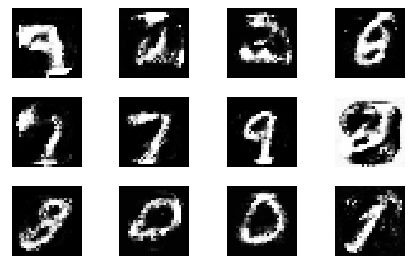

 50%|█████     | 151.00847457626716/300 [29:55<24:58, 10.05s/it]

	Epoch 151 of 300	Generator loss: 1.96069658, Discriminator loss: 2.42620516


 51%|█████     | 152.00847457626847/300 [30:07<26:14, 10.64s/it]

	Epoch 152 of 300	Generator loss: 1.90508044, Discriminator loss: 2.50892544


 51%|█████     | 153.01694915254097/300 [30:19<26:57, 11.01s/it]

	Epoch 153 of 300	Generator loss: 2.08988738, Discriminator loss: 2.47583437


 51%|█████▏    | 154.00847457627108/300 [30:30<24:37, 10.12s/it]

	Epoch 154 of 300	Generator loss: 2.07415557, Discriminator loss: 2.46530604


 52%|█████▏    | 155.0084745762724/300 [30:41<24:22, 10.09s/it]

	Epoch 155 of 300	Generator loss: 1.96873057, Discriminator loss: 2.43072891


 52%|█████▏    | 156.0084745762737/300 [30:52<23:52,  9.95s/it]

	Epoch 156 of 300	Generator loss: 2.00085974, Discriminator loss: 2.46419430


 52%|█████▏    | 157.008474576275/300 [31:03<23:48,  9.99s/it] 

	Epoch 157 of 300	Generator loss: 2.19585037, Discriminator loss: 2.40610337


 53%|█████▎    | 158.0084745762763/300 [31:14<27:51, 11.77s/it] 

	Epoch 158 of 300	Generator loss: 1.97759628, Discriminator loss: 2.45589256


 53%|█████▎    | 159.00847457627762/300 [31:27<26:57, 11.47s/it]

	Epoch 159 of 300	Generator loss: 1.89641416, Discriminator loss: 2.55542898


 53%|█████▎    | 160.01694915255013/300 [31:39<24:12, 10.37s/it]

	Epoch 160 of 300	Generator loss: 1.98952460, Discriminator loss: 2.46805906


 54%|█████▎    | 161.00847457628024/300 [31:51<27:09, 11.72s/it]

	Epoch 161 of 300	Generator loss: 1.90269601, Discriminator loss: 2.53783441


 54%|█████▍    | 162.00847457628154/300 [32:03<26:49, 11.67s/it]

	Epoch 162 of 300	Generator loss: 1.85946500, Discriminator loss: 2.56127572


 54%|█████▍    | 163.01694915255405/300 [32:15<24:19, 10.65s/it]

	Epoch 163 of 300	Generator loss: 1.99081886, Discriminator loss: 2.54377437


 55%|█████▍    | 164.01694915255536/300 [32:27<24:22, 10.76s/it]

	Epoch 164 of 300	Generator loss: 1.78274643, Discriminator loss: 2.61125135


 55%|█████▌    | 165.01694915255666/300 [32:38<24:02, 10.69s/it]

	Epoch 165 of 300	Generator loss: 1.85708070, Discriminator loss: 2.60031056


 55%|█████▌    | 166.01694915255797/300 [32:49<24:03, 10.78s/it]

	Epoch 166 of 300	Generator loss: 1.83098054, Discriminator loss: 2.63447070


 56%|█████▌    | 167.00847457628808/300 [33:01<25:35, 11.55s/it]

	Epoch 167 of 300	Generator loss: 1.79819345, Discriminator loss: 2.65217900


 56%|█████▌    | 168.0084745762894/300 [33:14<25:17, 11.50s/it]

	Epoch 168 of 300	Generator loss: 1.92025518, Discriminator loss: 2.63952494


 56%|█████▋    | 169.0084745762907/300 [33:25<22:03, 10.10s/it]

	Epoch 169 of 300	Generator loss: 1.92220438, Discriminator loss: 2.63683486


 57%|█████▋    | 170.008474576292/300 [33:36<22:20, 10.31s/it] 

	Epoch 170 of 300	Generator loss: 1.92234027, Discriminator loss: 2.59835148


 57%|█████▋    | 171.0084745762933/300 [33:47<22:16, 10.36s/it] 

	Epoch 171 of 300	Generator loss: 1.78839374, Discriminator loss: 2.64895153


 57%|█████▋    | 172.00847457629462/300 [33:59<25:40, 12.04s/it]

	Epoch 172 of 300	Generator loss: 1.71326303, Discriminator loss: 2.69342518


 58%|█████▊    | 173.00847457629592/300 [34:12<24:27, 11.56s/it]

	Epoch 173 of 300	Generator loss: 1.66628957, Discriminator loss: 2.72386146


 58%|█████▊    | 174.00847457629723/300 [34:24<21:25, 10.21s/it]

	Epoch 174 of 300	Generator loss: 1.73523736, Discriminator loss: 2.71403146


 58%|█████▊    | 175.00847457629854/300 [34:36<21:18, 10.23s/it]

	Epoch 175 of 300	Generator loss: 1.70177591, Discriminator loss: 2.73851132


 59%|█████▊    | 176.00847457629985/300 [34:47<21:05, 10.20s/it]

	Epoch 176 of 300	Generator loss: 1.77561879, Discriminator loss: 2.71673346


 59%|█████▉    | 177.00847457630115/300 [34:58<21:39, 10.56s/it]

	Epoch 177 of 300	Generator loss: 1.79158306, Discriminator loss: 2.77769542


 59%|█████▉    | 178.00847457630246/300 [35:10<23:47, 11.70s/it]

	Epoch 178 of 300	Generator loss: 1.93611205, Discriminator loss: 2.73666024


 60%|█████▉    | 179.00847457630377/300 [35:23<23:26, 11.63s/it]

	Epoch 179 of 300	Generator loss: 1.84129322, Discriminator loss: 2.75523591


 60%|██████    | 180.00847457630508/300 [35:35<20:47, 10.39s/it]

	Epoch 180 of 300	Generator loss: 1.83287764, Discriminator loss: 2.74235630


 60%|██████    | 181.00847457630638/300 [35:46<20:44, 10.46s/it]

	Epoch 181 of 300	Generator loss: 1.80223811, Discriminator loss: 2.75037313


 61%|██████    | 182.0084745763077/300 [35:58<20:31, 10.44s/it]

	Epoch 182 of 300	Generator loss: 1.85239398, Discriminator loss: 2.72568989


 61%|██████    | 183.008474576309/300 [36:09<24:31, 12.58s/it] 

	Epoch 183 of 300	Generator loss: 1.78554952, Discriminator loss: 2.77810049


 61%|██████▏   | 184.0084745763103/300 [36:22<22:25, 11.60s/it]

	Epoch 184 of 300	Generator loss: 1.83743525, Discriminator loss: 2.74684238


 62%|██████▏   | 185.0169491525828/300 [36:34<20:25, 10.66s/it] 

	Epoch 185 of 300	Generator loss: 1.79789865, Discriminator loss: 2.79123378


 62%|██████▏   | 186.00847457631292/300 [36:46<21:53, 11.52s/it]

	Epoch 186 of 300	Generator loss: 1.75952339, Discriminator loss: 2.78061199


 62%|██████▏   | 187.00847457631423/300 [36:59<22:20, 11.86s/it]

	Epoch 187 of 300	Generator loss: 1.74593079, Discriminator loss: 2.77122140


 63%|██████▎   | 188.00847457631554/300 [37:11<19:56, 10.68s/it]

	Epoch 188 of 300	Generator loss: 1.72174060, Discriminator loss: 2.78498220


 63%|██████▎   | 189.00847457631684/300 [37:22<19:01, 10.28s/it]

	Epoch 189 of 300	Generator loss: 1.78184247, Discriminator loss: 2.83530402


 63%|██████▎   | 190.00847457631815/300 [37:33<18:48, 10.26s/it]

	Epoch 190 of 300	Generator loss: 1.76924562, Discriminator loss: 2.80934715


 64%|██████▎   | 191.00847457631946/300 [37:45<19:13, 10.59s/it]

	Epoch 191 of 300	Generator loss: 1.73257101, Discriminator loss: 2.84552503


 64%|██████▍   | 192.00847457632076/300 [37:57<21:12, 11.79s/it]

	Epoch 192 of 300	Generator loss: 1.68584919, Discriminator loss: 2.81185532


 64%|██████▍   | 193.00847457632207/300 [38:10<20:58, 11.76s/it]

	Epoch 193 of 300	Generator loss: 1.70737541, Discriminator loss: 2.87018752


 65%|██████▍   | 194.01694915259458/300 [38:21<19:01, 10.77s/it]

	Epoch 194 of 300	Generator loss: 1.69879985, Discriminator loss: 2.82355547


 65%|██████▌   | 195.01694915259588/300 [38:33<18:38, 10.66s/it]

	Epoch 195 of 300	Generator loss: 1.67324138, Discriminator loss: 2.83578920


 65%|██████▌   | 196.0169491525972/300 [38:44<18:12, 10.51s/it]

	Epoch 196 of 300	Generator loss: 1.65266073, Discriminator loss: 2.86831355


 66%|██████▌   | 197.0084745763273/300 [38:56<19:57, 11.63s/it]

	Epoch 197 of 300	Generator loss: 1.69788611, Discriminator loss: 2.86758924


 66%|██████▌   | 198.0084745763286/300 [39:08<19:36, 11.53s/it] 

	Epoch 198 of 300	Generator loss: 1.65427709, Discriminator loss: 2.88627386


 66%|██████▋   | 199.01694915260111/300 [39:21<18:15, 10.85s/it]

	Epoch 199 of 300	Generator loss: 1.71679604, Discriminator loss: 2.87385559


 67%|██████▋   | 200.00000000006003/300 [39:32<18:00, 10.81s/it]

	Epoch 200 of 300	Generator loss: 1.65518951, Discriminator loss: 2.86807847


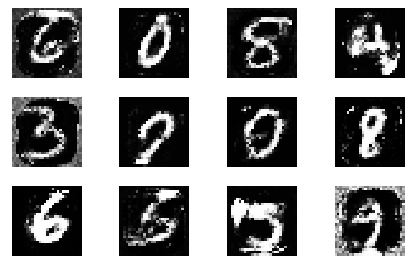

 67%|██████▋   | 201.01694915260373/300 [39:44<17:36, 10.67s/it]

	Epoch 201 of 300	Generator loss: 1.65487027, Discriminator loss: 2.86614370


 67%|██████▋   | 202.01694915260504/300 [39:56<17:23, 10.65s/it]

	Epoch 202 of 300	Generator loss: 1.82469547, Discriminator loss: 2.82705593


 68%|██████▊   | 203.00847457633515/300 [40:08<19:18, 11.94s/it]

	Epoch 203 of 300	Generator loss: 1.76778722, Discriminator loss: 2.82504487


 68%|██████▊   | 204.00847457633645/300 [40:21<18:30, 11.57s/it]

	Epoch 204 of 300	Generator loss: 1.70839787, Discriminator loss: 2.85927677


 68%|██████▊   | 205.00847457633776/300 [40:33<16:41, 10.54s/it]

	Epoch 205 of 300	Generator loss: 1.74987745, Discriminator loss: 2.86332393


 69%|██████▊   | 206.00847457633907/300 [40:45<16:58, 10.83s/it]

	Epoch 206 of 300	Generator loss: 1.77982843, Discriminator loss: 2.82975483


 69%|██████▉   | 207.01694915261157/300 [40:56<16:48, 10.85s/it]

	Epoch 207 of 300	Generator loss: 1.79673398, Discriminator loss: 2.86599708


 69%|██████▉   | 208.00847457634168/300 [41:08<18:03, 11.77s/it]

	Epoch 208 of 300	Generator loss: 1.69217277, Discriminator loss: 2.84966803


 70%|██████▉   | 209.008474576343/300 [41:21<17:29, 11.53s/it] 

	Epoch 209 of 300	Generator loss: 1.73504794, Discriminator loss: 2.86784244


 70%|███████   | 210.0084745763443/300 [41:33<15:29, 10.33s/it]

	Epoch 210 of 300	Generator loss: 1.69525349, Discriminator loss: 2.87915659


 70%|███████   | 211.0084745763456/300 [41:44<15:27, 10.42s/it]

	Epoch 211 of 300	Generator loss: 1.68828297, Discriminator loss: 2.86588669


 71%|███████   | 212.0084745763469/300 [41:56<15:10, 10.34s/it] 

	Epoch 212 of 300	Generator loss: 1.80129576, Discriminator loss: 2.86325836


 71%|███████   | 213.01694915261942/300 [42:07<16:12, 11.18s/it]

	Epoch 213 of 300	Generator loss: 1.76484275, Discriminator loss: 2.91222477


 71%|███████▏  | 214.00847457634953/300 [42:20<16:36, 11.58s/it]

	Epoch 214 of 300	Generator loss: 1.68365586, Discriminator loss: 2.91208625


 72%|███████▏  | 215.00847457635084/300 [42:32<16:11, 11.43s/it]

	Epoch 215 of 300	Generator loss: 1.64243221, Discriminator loss: 2.91285062


 72%|███████▏  | 216.00847457635214/300 [42:44<14:42, 10.51s/it]

	Epoch 216 of 300	Generator loss: 1.65073180, Discriminator loss: 2.88948107


 72%|███████▏  | 217.00847457635345/300 [42:57<16:13, 11.72s/it]

	Epoch 217 of 300	Generator loss: 1.60974085, Discriminator loss: 2.94856071


 73%|███████▎  | 218.00847457635476/300 [43:10<15:15, 11.16s/it]

	Epoch 218 of 300	Generator loss: 1.49836278, Discriminator loss: 2.94388223


 73%|███████▎  | 219.01694915262726/300 [43:21<14:12, 10.52s/it]

	Epoch 219 of 300	Generator loss: 1.51783109, Discriminator loss: 2.97316861


 73%|███████▎  | 220.01694915262857/300 [43:32<14:04, 10.56s/it]

	Epoch 220 of 300	Generator loss: 1.49812472, Discriminator loss: 2.96080351


 74%|███████▎  | 221.01694915262988/300 [43:44<14:06, 10.71s/it]

	Epoch 221 of 300	Generator loss: 1.44672048, Discriminator loss: 2.99166369


 74%|███████▍  | 222.00847457636/300 [43:55<14:54, 11.47s/it]  

	Epoch 222 of 300	Generator loss: 1.46665609, Discriminator loss: 3.01592064


 74%|███████▍  | 223.0084745763613/300 [44:08<15:08, 11.80s/it]

	Epoch 223 of 300	Generator loss: 1.49765658, Discriminator loss: 2.98457193


 75%|███████▍  | 224.0084745763626/300 [44:20<13:19, 10.51s/it]

	Epoch 224 of 300	Generator loss: 1.51746023, Discriminator loss: 2.97474885


 75%|███████▌  | 225.0084745763639/300 [44:32<13:02, 10.43s/it]

	Epoch 225 of 300	Generator loss: 1.46750247, Discriminator loss: 2.99951100


 75%|███████▌  | 226.0169491526364/300 [44:43<13:26, 10.89s/it] 

	Epoch 226 of 300	Generator loss: 1.44155395, Discriminator loss: 3.02275109


 76%|███████▌  | 227.01694915263772/300 [44:55<13:06, 10.77s/it]

	Epoch 227 of 300	Generator loss: 1.39533186, Discriminator loss: 2.98745465


 76%|███████▌  | 228.00847457636783/300 [45:07<14:01, 11.68s/it]

	Epoch 228 of 300	Generator loss: 1.36851454, Discriminator loss: 3.02613807


 76%|███████▋  | 229.00847457636914/300 [45:20<14:04, 11.90s/it]

	Epoch 229 of 300	Generator loss: 1.40492332, Discriminator loss: 3.02960324


 77%|███████▋  | 230.00847457637045/300 [45:32<12:09, 10.42s/it]

	Epoch 230 of 300	Generator loss: 1.35821962, Discriminator loss: 3.03725910


 77%|███████▋  | 231.00847457637175/300 [45:43<11:47, 10.26s/it]

	Epoch 231 of 300	Generator loss: 1.34604347, Discriminator loss: 3.01850700


 77%|███████▋  | 232.00847457637306/300 [45:55<12:11, 10.77s/it]

	Epoch 232 of 300	Generator loss: 1.32623243, Discriminator loss: 3.02647591


 78%|███████▊  | 233.00847457637437/300 [46:07<13:05, 11.72s/it]

	Epoch 233 of 300	Generator loss: 1.32069027, Discriminator loss: 3.03744292


 78%|███████▊  | 234.00847457637568/300 [46:19<12:47, 11.62s/it]

	Epoch 234 of 300	Generator loss: 1.31888545, Discriminator loss: 3.03771591


 78%|███████▊  | 235.00847457637698/300 [46:31<11:13, 10.37s/it]

	Epoch 235 of 300	Generator loss: 1.35777748, Discriminator loss: 3.02868485


 79%|███████▊  | 236.0084745763783/300 [46:43<11:34, 10.85s/it]

	Epoch 236 of 300	Generator loss: 1.32111573, Discriminator loss: 3.03511214


 79%|███████▉  | 237.0084745763796/300 [46:54<11:09, 10.63s/it]

	Epoch 237 of 300	Generator loss: 1.31572199, Discriminator loss: 3.04567242


 79%|███████▉  | 238.0169491526521/300 [47:06<11:10, 10.81s/it]

	Epoch 238 of 300	Generator loss: 1.32533216, Discriminator loss: 3.06690979


 80%|███████▉  | 239.0084745763822/300 [47:18<11:52, 11.69s/it] 

	Epoch 239 of 300	Generator loss: 1.30322921, Discriminator loss: 3.07944846


 80%|████████  | 240.00847457638352/300 [47:31<11:51, 11.86s/it]

	Epoch 240 of 300	Generator loss: 1.37051415, Discriminator loss: 3.05560064


 80%|████████  | 241.00847457638483/300 [47:43<11:29, 11.69s/it]

	Epoch 241 of 300	Generator loss: 1.31907082, Discriminator loss: 3.08803511


 81%|████████  | 242.00847457638613/300 [47:56<11:08, 11.53s/it]

	Epoch 242 of 300	Generator loss: 1.33560550, Discriminator loss: 3.05572963


 81%|████████  | 243.00847457638744/300 [48:09<09:54, 10.43s/it]

	Epoch 243 of 300	Generator loss: 1.30740249, Discriminator loss: 3.04640579


 81%|████████▏ | 244.00847457638875/300 [48:20<09:34, 10.26s/it]

	Epoch 244 of 300	Generator loss: 1.25577307, Discriminator loss: 3.07819819


 82%|████████▏ | 245.00847457639006/300 [48:31<09:32, 10.42s/it]

	Epoch 245 of 300	Generator loss: 1.25196195, Discriminator loss: 3.09104872


 82%|████████▏ | 246.00847457639136/300 [48:42<09:20, 10.38s/it]

	Epoch 246 of 300	Generator loss: 1.22783589, Discriminator loss: 3.08393264


 82%|████████▏ | 247.00847457639267/300 [48:54<10:25, 11.80s/it]

	Epoch 247 of 300	Generator loss: 1.22459674, Discriminator loss: 3.10815835


 83%|████████▎ | 248.00847457639398/300 [49:07<10:24, 12.00s/it]

	Epoch 248 of 300	Generator loss: 1.23553252, Discriminator loss: 3.09913158


 83%|████████▎ | 249.01694915266648/300 [49:19<09:08, 10.76s/it]

	Epoch 249 of 300	Generator loss: 1.24069154, Discriminator loss: 3.10978127


 83%|████████▎ | 250.0000000001254/300 [49:30<08:41, 10.42s/it]

	Epoch 250 of 300	Generator loss: 1.25453401, Discriminator loss: 3.11092019


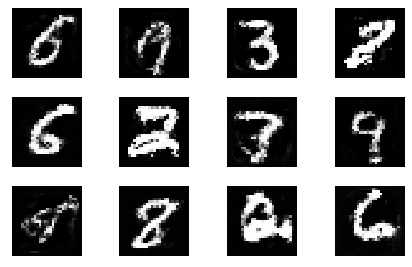

 84%|████████▎ | 251.0084745763979/300 [49:43<08:30, 10.41s/it]

	Epoch 251 of 300	Generator loss: 1.20782959, Discriminator loss: 3.10630989


 84%|████████▍ | 252.0084745763992/300 [49:54<08:33, 10.69s/it]

	Epoch 252 of 300	Generator loss: 1.21052897, Discriminator loss: 3.09385371


 84%|████████▍ | 253.00847457640052/300 [50:07<09:13, 11.78s/it]

	Epoch 253 of 300	Generator loss: 1.18466318, Discriminator loss: 3.10048652


 85%|████████▍ | 254.00847457640182/300 [50:19<08:06, 10.58s/it]

	Epoch 254 of 300	Generator loss: 1.18159676, Discriminator loss: 3.11349130


 85%|████████▌ | 255.00847457640313/300 [50:31<08:13, 10.97s/it]

	Epoch 255 of 300	Generator loss: 1.21027923, Discriminator loss: 3.10693645


 85%|████████▌ | 256.0084745764044/300 [50:42<07:30, 10.23s/it] 

	Epoch 256 of 300	Generator loss: 1.19526863, Discriminator loss: 3.09448552


 86%|████████▌ | 257.00847457640236/300 [50:54<07:30, 10.48s/it]

	Epoch 257 of 300	Generator loss: 1.20108783, Discriminator loss: 3.11140800


 86%|████████▌ | 258.0084745764003/300 [51:06<08:07, 11.61s/it]

	Epoch 258 of 300	Generator loss: 1.19142473, Discriminator loss: 3.09276080


 86%|████████▋ | 259.00847457639827/300 [51:19<08:24, 12.31s/it]

	Epoch 259 of 300	Generator loss: 1.19671941, Discriminator loss: 3.11474276


 87%|████████▋ | 260.0084745763962/300 [51:31<06:58, 10.47s/it]

	Epoch 260 of 300	Generator loss: 1.16520476, Discriminator loss: 3.11160374


 87%|████████▋ | 261.01694915266535/300 [51:42<06:49, 10.49s/it]

	Epoch 261 of 300	Generator loss: 1.15982115, Discriminator loss: 3.11498904


 87%|████████▋ | 262.0169491526633/300 [51:54<06:50, 10.81s/it] 

	Epoch 262 of 300	Generator loss: 1.14751279, Discriminator loss: 3.11684084


 88%|████████▊ | 263.01694915266125/300 [52:05<06:45, 10.96s/it]

	Epoch 263 of 300	Generator loss: 1.13610446, Discriminator loss: 3.12566042


 88%|████████▊ | 264.00847457638804/300 [52:18<07:20, 12.24s/it]

	Epoch 264 of 300	Generator loss: 1.12711525, Discriminator loss: 3.08314252


 88%|████████▊ | 265.008474576386/300 [52:31<06:57, 11.92s/it]  

	Epoch 265 of 300	Generator loss: 1.12306595, Discriminator loss: 3.10969067


 89%|████████▊ | 266.00847457638395/300 [52:42<05:56, 10.48s/it]

	Epoch 266 of 300	Generator loss: 1.10241616, Discriminator loss: 3.07153726


 89%|████████▉ | 267.0084745763819/300 [52:54<05:51, 10.66s/it] 

	Epoch 267 of 300	Generator loss: 1.12491179, Discriminator loss: 3.06361651


 89%|████████▉ | 268.00847457637985/300 [53:05<05:33, 10.42s/it]

	Epoch 268 of 300	Generator loss: 1.14891171, Discriminator loss: 3.00362396


 90%|████████▉ | 269.0084745763778/300 [53:17<05:49, 11.27s/it] 

	Epoch 269 of 300	Generator loss: 1.11904049, Discriminator loss: 3.03931117


 90%|█████████ | 270.00847457637576/300 [53:30<05:49, 11.65s/it]

	Epoch 270 of 300	Generator loss: 1.12160206, Discriminator loss: 3.05469394


 90%|█████████ | 271.0084745763737/300 [53:42<05:09, 10.69s/it]

	Epoch 271 of 300	Generator loss: 1.12246621, Discriminator loss: 3.03101015


 91%|█████████ | 272.00847457637167/300 [53:55<05:29, 11.77s/it]

	Epoch 272 of 300	Generator loss: 1.11499047, Discriminator loss: 3.05853367


 91%|█████████ | 273.0084745763696/300 [54:08<05:08, 11.44s/it]

	Epoch 273 of 300	Generator loss: 1.11162400, Discriminator loss: 3.08769703


 91%|█████████▏| 274.0084745763676/300 [54:20<04:32, 10.49s/it] 

	Epoch 274 of 300	Generator loss: 1.10767961, Discriminator loss: 3.06547642


 92%|█████████▏| 275.00847457636553/300 [54:31<04:19, 10.39s/it]

	Epoch 275 of 300	Generator loss: 1.09838629, Discriminator loss: 3.07523918


 92%|█████████▏| 276.0084745763635/300 [54:42<04:12, 10.51s/it] 

	Epoch 276 of 300	Generator loss: 1.09147954, Discriminator loss: 3.07914233


 92%|█████████▏| 277.00847457636144/300 [54:54<04:23, 11.44s/it]

	Epoch 277 of 300	Generator loss: 1.08205247, Discriminator loss: 3.10133934


 93%|█████████▎| 278.0084745763594/300 [55:07<04:21, 11.88s/it] 

	Epoch 278 of 300	Generator loss: 1.08605361, Discriminator loss: 3.07705188


 93%|█████████▎| 279.0169491526285/300 [55:19<03:47, 10.86s/it]

	Epoch 279 of 300	Generator loss: 1.09748411, Discriminator loss: 3.04185820


 93%|█████████▎| 280.01694915262647/300 [55:31<03:43, 11.16s/it]

	Epoch 280 of 300	Generator loss: 1.07408369, Discriminator loss: 3.11660409


 94%|█████████▎| 281.0169491526244/300 [55:42<03:22, 10.65s/it]

	Epoch 281 of 300	Generator loss: 1.09444678, Discriminator loss: 3.06643057


 94%|█████████▍| 282.0169491526224/300 [55:54<03:18, 11.06s/it] 

	Epoch 282 of 300	Generator loss: 1.10033607, Discriminator loss: 3.05566263


 94%|█████████▍| 283.00847457634916/300 [56:06<03:20, 11.81s/it]

	Epoch 283 of 300	Generator loss: 1.08853877, Discriminator loss: 3.10730314


 95%|█████████▍| 284.0084745763471/300 [56:19<03:03, 11.46s/it]

	Epoch 284 of 300	Generator loss: 1.10214341, Discriminator loss: 3.06391382


 95%|█████████▌| 285.00847457634507/300 [56:31<02:40, 10.73s/it]

	Epoch 285 of 300	Generator loss: 1.08780134, Discriminator loss: 3.12838197


 95%|█████████▌| 286.008474576343/300 [56:42<02:35, 11.11s/it] 

	Epoch 286 of 300	Generator loss: 1.06956995, Discriminator loss: 3.10998917


 96%|█████████▌| 287.01694915261214/300 [56:54<02:27, 11.36s/it]

	Epoch 287 of 300	Generator loss: 1.07105875, Discriminator loss: 3.13987517


 96%|█████████▌| 288.0084745763389/300 [57:05<02:21, 11.78s/it]

	Epoch 288 of 300	Generator loss: 1.06001997, Discriminator loss: 3.12380552


 96%|█████████▋| 289.0084745763369/300 [57:18<02:09, 11.82s/it] 

	Epoch 289 of 300	Generator loss: 1.07727313, Discriminator loss: 3.11833167


 97%|█████████▋| 290.016949152606/300 [57:31<01:50, 11.08s/it]  

	Epoch 290 of 300	Generator loss: 1.08335710, Discriminator loss: 3.10228992


 97%|█████████▋| 291.01694915260396/300 [57:42<01:37, 10.90s/it]

	Epoch 291 of 300	Generator loss: 1.07572961, Discriminator loss: 3.09532952


 97%|█████████▋| 292.0169491526019/300 [57:53<01:25, 10.75s/it]

	Epoch 292 of 300	Generator loss: 1.06222486, Discriminator loss: 3.10947514


 98%|█████████▊| 293.0084745763287/300 [58:05<01:12, 10.42s/it] 

	Epoch 293 of 300	Generator loss: 1.05928636, Discriminator loss: 3.14656162


 98%|█████████▊| 294.00847457632665/300 [58:17<01:10, 11.69s/it]

	Epoch 294 of 300	Generator loss: 1.06061947, Discriminator loss: 3.12234569


 98%|█████████▊| 295.0084745763246/300 [58:30<00:58, 11.75s/it] 

	Epoch 295 of 300	Generator loss: 1.05226862, Discriminator loss: 3.15078950


 99%|█████████▊| 296.0169491525937/300 [58:42<00:42, 10.78s/it]

	Epoch 296 of 300	Generator loss: 1.05604374, Discriminator loss: 3.14872813


 99%|█████████▉| 297.0084745763205/300 [58:54<00:34, 11.53s/it] 

	Epoch 297 of 300	Generator loss: 1.06820822, Discriminator loss: 3.13294220


 99%|█████████▉| 298.00847457631846/300 [59:07<00:23, 11.62s/it]

	Epoch 298 of 300	Generator loss: 1.06340778, Discriminator loss: 3.13046479


100%|█████████▉| 299.0084745763164/300 [59:18<00:10, 10.42s/it]

	Epoch 299 of 300	Generator loss: 1.05578732, Discriminator loss: 3.10858345


100%|█████████▉| 299.99152542377203/300 [59:30<00:00, 11.19s/it]

	Epoch 300 of 300	Generator loss: 1.04825723, Discriminator loss: 3.12493205


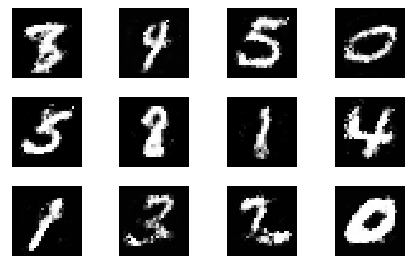

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
100%|██████████| 300.0000000000432/300 [59:30<00:00, 11.90s/it] 


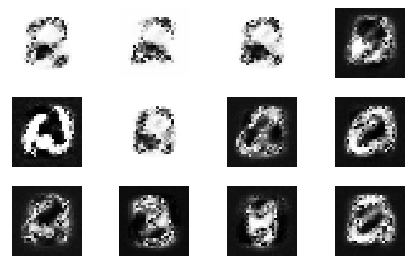

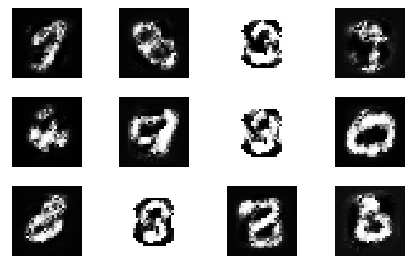

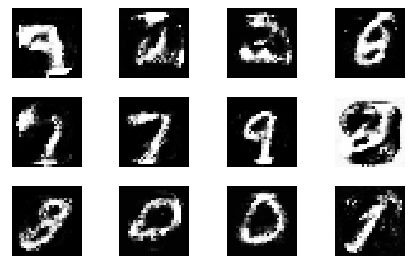

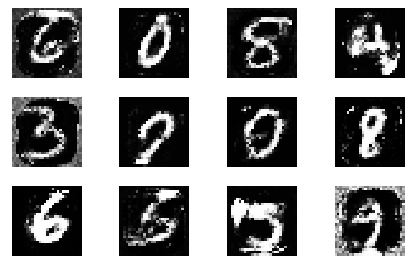

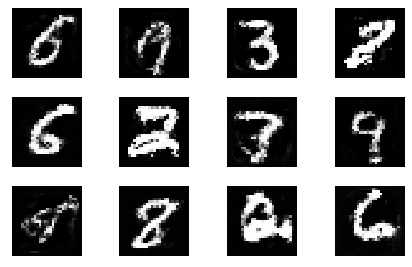

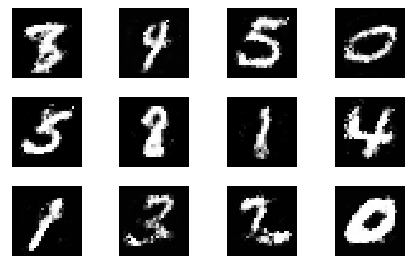

In [10]:
pbar_update = 1 / len(train_loader)

losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

# create the noise vector
noise = create_noise(sample_size, nz)
generator.train()
discriminator.train()

with tqdm(total=epochs) as pbar:
  for epoch in range(1, epochs + 1):
      loss_g = 0.0
      loss_d = 0.0

      for bi, data in enumerate(train_loader):
          image, _ = data
          image = image.to(device)
          b_size = len(image)
          
          # run the discriminator for k number of steps
          for step in range(k):
              data_fake = generator(create_noise(b_size, nz)).detach()
              data_real = image

              # train the discriminator network
              loss_d += train_discriminator(optim_d, data_real, data_fake)
          
          data_fake = generator(create_noise(b_size, nz))
          
          # train the generator network
          loss_g += train_generator(optim_g, data_fake)
      
      # create the final fake image for the epoch and add to array to create gif
      generated_img = generator(noise).cpu().detach()
      generated_img = make_grid(generated_img)
      images.append(generated_img)

      epoch_loss_g = loss_g / bi # total generator loss for the epoch
      epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
      losses_g.append(epoch_loss_g)
      losses_d.append(epoch_loss_d)
      
      print(f"\tEpoch {epoch} of {epochs}", end="\t")
      print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

      if (epoch + 50) % 50 == 0:
          display(show_pics())

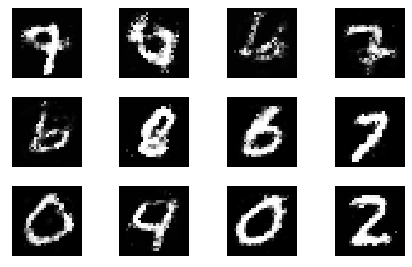

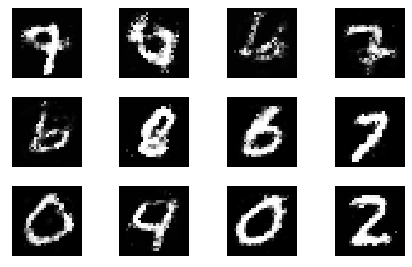

In [11]:
display(show_pics())

In [13]:
from IPython.display import Image

imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('generator_images.gif', imgs)
Image(open('generator_images.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

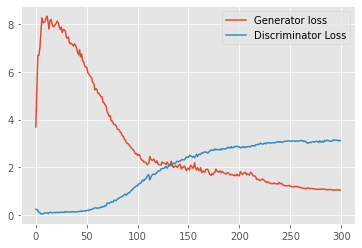

In [14]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.show()